In [25]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import textstat
from evaluate import load
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/afnanmir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Loading in our predictions for the test set**

In [125]:
predictions = load_dataset("json", data_files="./plos_readability_ctrl_sum_corpus_output_update/test_plos_output.jsonl")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /Users/afnanmir/.cache/huggingface/datasets/json/default-03cb34fe6e7f8ec0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

**Load the full test set, with the abstract, article, and plain language summary.**

In [12]:
test_set = load_dataset("json", data_files="./plos_readability_ctrl_sum_corpus/test_plos.jsonl")

Found cached dataset json (/Users/afnanmir/.cache/huggingface/datasets/json/default-41361f8d4436d3ef/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Define a function t get the rouge scores for a given prediction and reference.

In [128]:
rouge = load("rouge")
def compute_rouge(prediction, reference):
    rouge_output = rouge.compute(predictions=prediction, references=reference, rouge_types=["rouge1", "rouge2", "rougeL", "rougeLsum"], use_stemmer=True)
    return rouge_output

In [129]:
checkpoint = "afnanmmir/t5-base-abstract-to-plain-language-1"

def load_model(checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
    return tokenizer, model

In [130]:
tokenizer, model = load_model(checkpoint)

In [131]:
def compute_readability(summary):
    flesch = textstat.flesch_reading_ease(summary)
    dalle_chall = textstat.dale_chall_readability_score(summary)
    dalle_chall_v2 = textstat.dale_chall_readability_score_v2(summary)
    return {"flesch": flesch, "dale_chall": dalle_chall, "dale_chall_v2": dalle_chall_v2}

In [132]:
# compute the readability metrics for the generated summaries
readability_metrics_generated = []
readability_metrics_original = []
readability_metrics_abstract = []

for i in range(len(predictions['train'])):
    readability_generated = compute_readability(predictions['train'][i]['predicted summary'])
    readability_metrics_generated.append(readability_generated)
    readability_original = compute_readability(test_set['train'][i]['plain language summary'])
    readability_metrics_original.append(readability_original)
    readability_abstract = compute_readability(test_set['train'][i]['abstract'])
    readability_metrics_abstract.append(readability_abstract)

    if(i%100 == 0):
        print(f"finished sample {i}")
# extract all the predicited summaries from predictions
predicted_summaries = [predictions['train'][i]['predicted summary'] for i in range(len(predictions['train']))]
plain_language_summaries = [test_set['train'][i]['plain language summary'] for i in range(len(test_set['train']))]
#compute the rouge scores
rouge_scores = compute_rouge(predicted_summaries, plain_language_summaries)

finished sample 0
finished sample 100
finished sample 200
finished sample 300
finished sample 400
finished sample 500
finished sample 600
finished sample 700
finished sample 800
finished sample 900


In [133]:
rouge_scores

{'rouge1': 0.4035898902662802,
 'rouge2': 0.12494823022687662,
 'rougeL': 0.2140034416927858,
 'rougeLsum': 0.21787105385907846}

In [134]:
generated_text_readability_metrics = {"flesch": [], "dale_chall": [], "dale_chall_v2": []}
original_text_readability_metrics = {"flesch": [], "dale_chall": [], "dale_chall_v2": []}
abstract_text_readability_metrics = {"flesch": [], "dale_chall": [], "dale_chall_v2": []}

for i in range(len(predictions['train'])):
    generated_text_readability_metrics['flesch'].append(readability_metrics_generated[i]['flesch'])
    generated_text_readability_metrics['dale_chall'].append(readability_metrics_generated[i]['dale_chall'])
    generated_text_readability_metrics['dale_chall_v2'].append(readability_metrics_generated[i]['dale_chall_v2'])
    original_text_readability_metrics['flesch'].append(readability_metrics_original[i]['flesch'])
    original_text_readability_metrics['dale_chall'].append(readability_metrics_original[i]['dale_chall'])
    original_text_readability_metrics['dale_chall_v2'].append(readability_metrics_original[i]['dale_chall_v2'])
    abstract_text_readability_metrics['flesch'].append(readability_metrics_abstract[i]['flesch'])
    abstract_text_readability_metrics['dale_chall'].append(readability_metrics_abstract[i]['dale_chall'])
    abstract_text_readability_metrics['dale_chall_v2'].append(readability_metrics_abstract[i]['dale_chall_v2'])

In [135]:
rouge_scores

{'rouge1': 0.4035898902662802,
 'rouge2': 0.12494823022687662,
 'rougeL': 0.2140034416927858,
 'rougeLsum': 0.21787105385907846}

In [136]:
print(f"Average Flesch for Predicted Summaries: {sum(generated_text_readability_metrics['flesch'])/len(generated_text_readability_metrics['flesch'])}")
print(f"Average Flesch for Abstract Summaries: {sum(abstract_text_readability_metrics['flesch'])/len(abstract_text_readability_metrics['flesch'])}")
print(f"Average Flesch for Original Summaries: {sum(original_text_readability_metrics['flesch'])/len(original_text_readability_metrics['flesch'])}")

Average Flesch for Predicted Summaries: 16.852250000000026
Average Flesch for Abstract Summaries: 27.449230000000004
Average Flesch for Original Summaries: 29.32751999999999


In [137]:
print(f"Average Dale Chall for Predicted Summaries: {sum(generated_text_readability_metrics['dale_chall'])/len(generated_text_readability_metrics['dale_chall'])}")
print(f"Average Dale Chall for Abstract Summaries: {sum(abstract_text_readability_metrics['dale_chall'])/len(abstract_text_readability_metrics['dale_chall'])}")
print(f"Average Dale Chall for Original Summaries: {sum(original_text_readability_metrics['dale_chall'])/len(original_text_readability_metrics['dale_chall'])}")

Average Dale Chall for Predicted Summaries: 12.270629999999999
Average Dale Chall for Abstract Summaries: 11.035999999999989
Average Dale Chall for Original Summaries: 10.899199999999997


In [138]:
print(f"Average Dale Chall v2 for Predicted Summaries: {sum(generated_text_readability_metrics['dale_chall_v2'])/len(generated_text_readability_metrics['dale_chall_v2'])}")
print(f"Average Dale Chall v2 for Abstract Summaries: {sum(abstract_text_readability_metrics['dale_chall_v2'])/len(abstract_text_readability_metrics['dale_chall_v2'])}")
print(f"Average Dale Chall v2 for Original Summaries: {sum(original_text_readability_metrics['dale_chall_v2'])/len(original_text_readability_metrics['dale_chall_v2'])}")

Average Dale Chall v2 for Predicted Summaries: 10.883999999999988
Average Dale Chall v2 for Abstract Summaries: 9.643939999999994
Average Dale Chall v2 for Original Summaries: 9.780719999999997


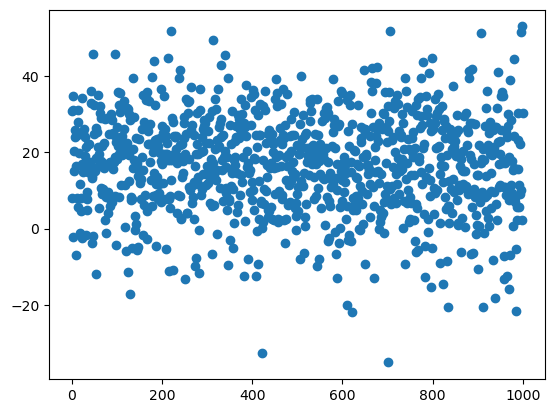

In [140]:
import matplotlib.pyplot as plt
import numpy as np
# remove outliers from the flesch scores of the predicted summaries

# plot the flesch scores of predicted summaries as a scatterplot
plt.scatter(np.arange(len(generated_text_readability_metrics['flesch'])), generated_text_readability_metrics['flesch'], label='Predicted Summaries')

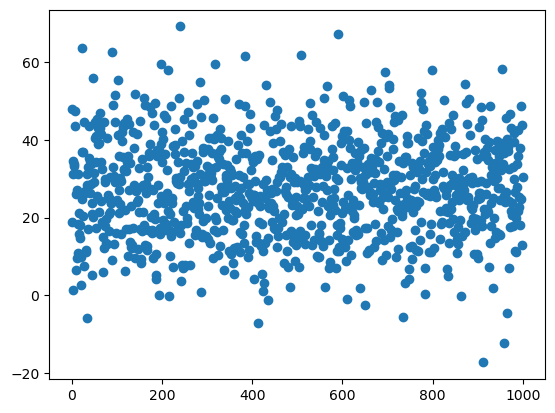

In [141]:
# plot the flesch scores of abstract summaries as a scatterplot
plt.scatter(np.arange(len(abstract_text_readability_metrics['flesch'])), abstract_text_readability_metrics['flesch'], label='Abstract Summaries')

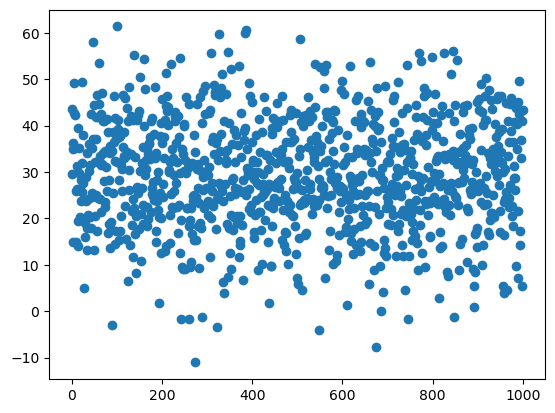

In [142]:
# plot the flesch scores of original summaries as a scatterplot
plt.scatter(np.arange(len(original_text_readability_metrics['flesch'])), original_text_readability_metrics['flesch'], label='Original Summaries')

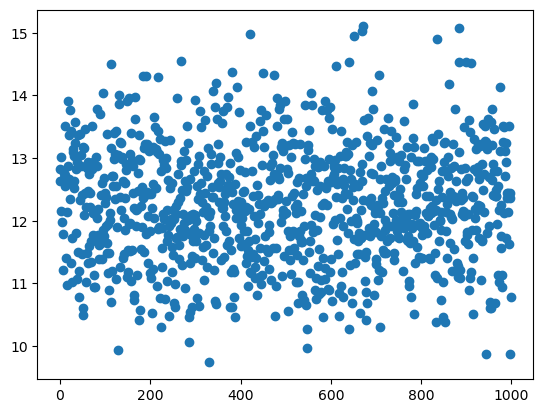

In [143]:
# plot the Dale Chall scores of predicted summaries as a scatterplot
plt.scatter(np.arange(len(generated_text_readability_metrics['dale_chall'])), generated_text_readability_metrics['dale_chall'], label='Predicted Summaries')

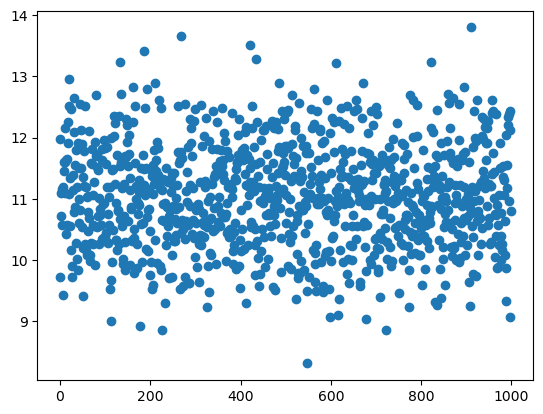

In [145]:
# plot the Dale Chall scores of abstract summaries as a scatterplot
plt.scatter(np.arange(len(abstract_text_readability_metrics['dale_chall'])), abstract_text_readability_metrics['dale_chall'], label='Abstract Summaries')

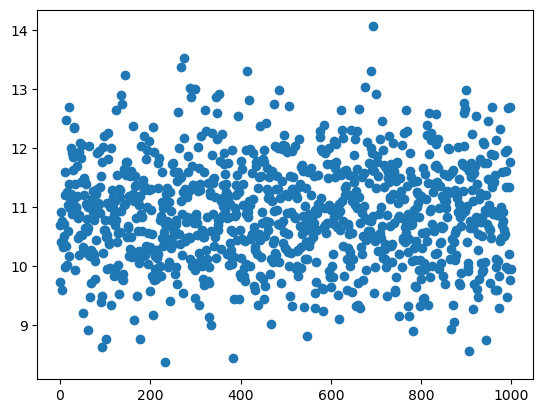

In [148]:
# plot the Dale Chall scores of original summaries as a scatterplot
plt.scatter(np.arange(len(original_text_readability_metrics['dale_chall'])), original_text_readability_metrics['dale_chall'], label='Original Summaries')

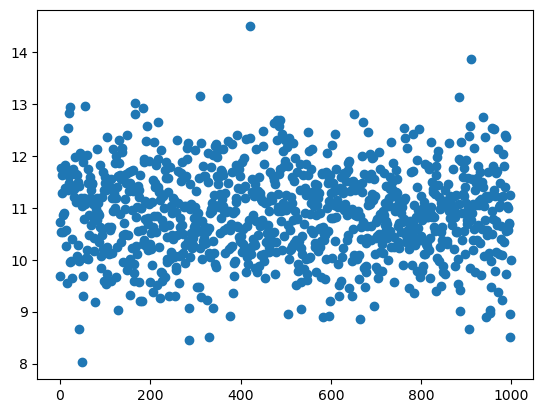

In [150]:
# plot the Dale Chall v2 scores of predicted summaries as a scatterplot
plt.scatter(np.arange(len(generated_text_readability_metrics['dale_chall_v2'])), generated_text_readability_metrics['dale_chall_v2'], label='Predicted Summaries')


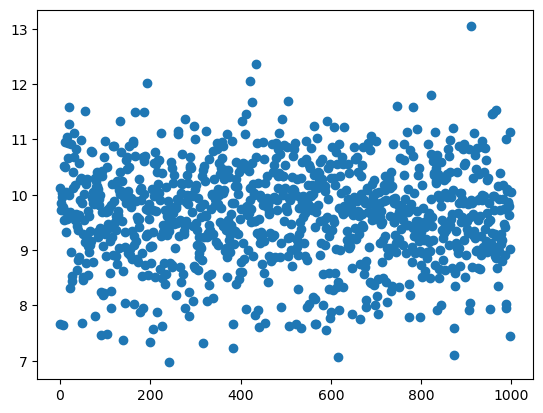

In [151]:
# plot the Dale Chall v2 scores of abstract summaries as a scatterplot
plt.scatter(np.arange(len(abstract_text_readability_metrics['dale_chall_v2'])), abstract_text_readability_metrics['dale_chall_v2'], label='Abstract Summaries')

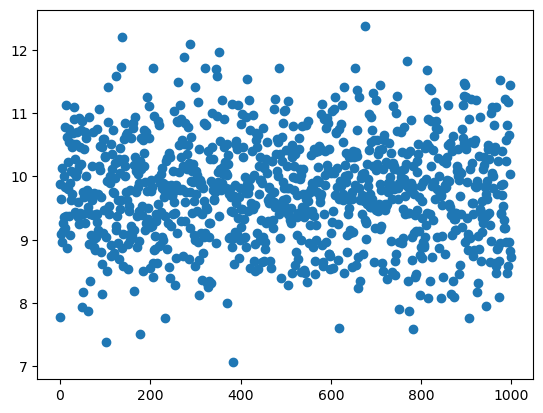

In [152]:
# plot the Dale Chall v2 scores of original summaries as a scatterplot
plt.scatter(np.arange(len(original_text_readability_metrics['dale_chall_v2'])), original_text_readability_metrics['dale_chall_v2'], label='Original Summaries')

In [153]:
test_set["train"][0]["abstract"]

'Aberrant CpG methylation is a universal epigenetic trait of cancer cell genomes. However, human cancer samples or cell lines preclude the investigation of epigenetic changes occurring early during tumour development. Here, we have used MeDIP-seq to analyse the DNA methylome of APCMin adenoma as a model for intestinal cancer initiation, and we present a list of more than 13,000 recurring differentially methylated regions (DMRs) characterizing intestinal adenoma of the mouse. We show that Polycomb Repressive Complex (PRC) targets are strongly enriched among hypermethylated DMRs, and several PRC2 components and DNA methyltransferases were up-regulated in adenoma. We further demonstrate by bisulfite pyrosequencing of purified cell populations that the DMR signature arises de novo in adenoma cells rather than by expansion of a pre-existing pattern in intestinal stem cells or undifferentiated crypt cells. We found that epigenetic silencing of tumour suppressors, which occurs frequently in c